## Library Imports

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
#import pillow as pil
%matplotlib inline

In [2]:
DATA_PATH = 'SampleData'
NUM_LAYERS_TO_REMOVE = 5
NUM_LAYERS_TO_TRAIN = 20

## Create image pre-processing function

In [3]:
# Function to preprocess the image with Keras
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
#def image_preprocessing(file):
#    img = image.load_img(file, target_size=(224, 224))
#    img_array = image.img_to_array(img)
#    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
#    return tf.keras.applications.mobilenet_v3.preprocess_input(img_array_expanded_dims)

## Load the metadata file.  Create a ground truth column.

In [4]:
# Load the metadata file
metadata = pd.read_excel('metadata_modified.xlsx')
image_path = metadata['Image Path']
# Create the ground truth values and put it into a new 'g_truth' column
g_truth = metadata['Malignant'] + metadata['A']*2 + metadata['F']*4 + metadata['PT']*8 + metadata['TA']*16 + metadata['DC']*32 + metadata['LC']*64 + metadata['MC']*128 + metadata['PC']*256
metadata['g_truth'] = g_truth

## Display a test image

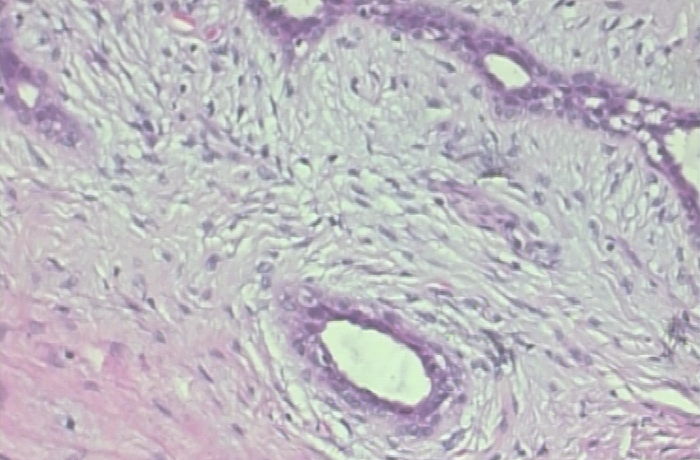

In [5]:
# Display test image
from IPython.display import Image
Image(filename=image_path[0], width=300,height=200)

In [6]:
mobile_v3 = tf.keras.applications.MobileNetV3Large()
#preprocessed_image = image_preprocessing(image_path[7117])
#predictions = mobile_v3.predict(preprocessed_image)
#print("Output shape: ", predictions.shape)
#results = imagenet_utils.decode_predictions(predictions)
#results

Remove the specifiied number of layers.
Freeze the specified number of layers.

In [7]:
# Remove last layers
#x = mobile_v3.layers[-NUM_LAYERS_TO_REMOVE].output
#output = Dense(units=2, activation='softmax')(x)

# Freeze layers
#for layer in new_model.layers[:-NUM_LAYERS_TO_TRAIN]:
#    layer.trainable = False                            

## Define the training and validation datasets

In [8]:
path_to_files = 'BreaKHis_v1/histology_slides/breast/'
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_files,
  validation_split=0.25,
  subset="training",
  seed=42,
  image_size=(224, 224),
#  batch_size=32,
  shuffle=True
)
  
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_files,
  validation_split=0.25,
  subset="validation",
  seed=42,
  image_size=(224, 224),
#  batch_size=32,
  shuffle=True
)
#val_batches = tf.data.experimental.cardinality(val_dataset)
#val_dataset = val_dataset.take((2*val_batches) // 5)
#test_dataset = val_dataset.skip((2*val_batches) // 5)


Found 7909 files belonging to 8 classes.
Using 5932 files for training.
Found 7909 files belonging to 8 classes.
Using 1977 files for validation.


## Use AUTOTUNE to decrease I/O roadblocks

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Define the model

In [10]:
IMG_SIZE=(224,224)
IMG_SHAPE = IMG_SIZE + (3,)
def new_model (image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                        include_top=False, # important
                                                        weights='imagenet')
    # freeze the base model
    base_model.trainable = False
    # create input layer
    inputs = tf.keras.Input(shape=input_shape)
    # pre-process inputs
    x = preprocess_input(inputs)
    # set training to False to avoid tracking statistics in batch norm layer
    x = base_model(x, training=False)
    # add flatten layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(8, activation='relu')(x)
    outputs = x

    model = tf.keras.Model(inputs,outputs)
    return model

## Train the model

In [11]:
project5_model = new_model(IMG_SIZE)
base_learning_rate = 0.1
opt = tf.keras.optimizers.legacy.SGD(learning_rate=base_learning_rate, momentum=0.9)
project5_model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

initial_epochs = 20
history = project5_model.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs)
project5_model.summary()

Epoch 1/20
186/186 [==============================] - 53s 277ms/step - loss: 2.0320 - accuracy: 0.3139 - val_loss: 1.6462 - val_accuracy: 0.3743
Epoch 2/20
186/186 [==============================] - 52s 275ms/step - loss: 1.5434 - accuracy: 0.4024 - val_loss: 1.6040 - val_accuracy: 0.3804
Epoch 3/20
186/186 [==============================] - 52s 275ms/step - loss: 1.3696 - accuracy: 0.4606 - val_loss: 1.5479 - val_accuracy: 0.4365
Epoch 4/20
186/186 [==============================] - 52s 276ms/step - loss: 1.2847 - accuracy: 0.4772 - val_loss: 1.5619 - val_accuracy: 0.4143
Epoch 5/20
186/186 [==============================] - 52s 277ms/step - loss: 1.1659 - accuracy: 0.5120 - val_loss: 1.5689 - val_accuracy: 0.4664
Epoch 6/20
186/186 [==============================] - 52s 278ms/step - loss: 1.0422 - accuracy: 0.5890 - val_loss: 1.4166 - val_accuracy: 0.5569
Epoch 7/20
186/186 [==============================] - 53s 282ms/step - loss: 0.8679 - accuracy: 0.6686 - val_loss: 1.6576 - val_ac

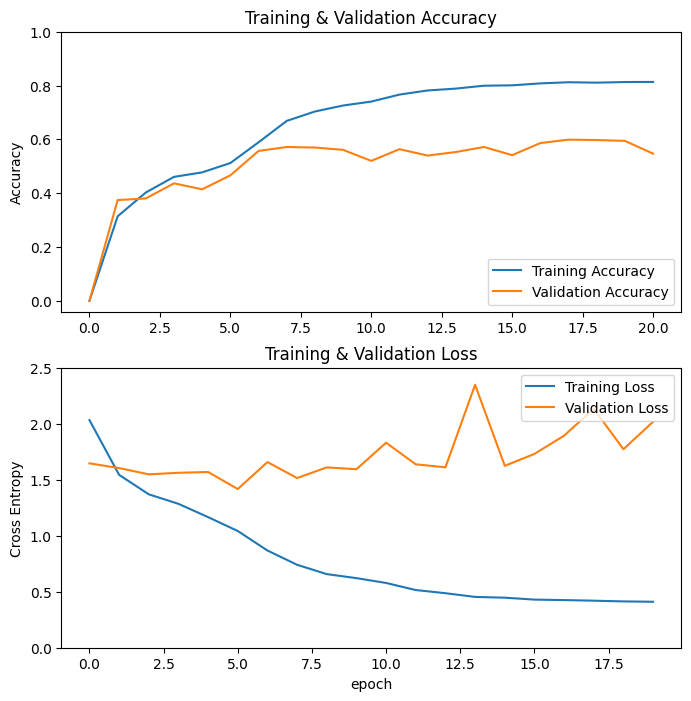

In [14]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training & Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training & Validation Loss')
plt.xlabel('epoch')
plt.show()